# Marshall JMP's modeling using a recurrent neural network.

This notebook ran on Kaggle with GPU. The dataset used was **tube-guitar-amplifiers-v1** (https://www.kaggle.com/filipechagas/tube-guitar-amplifiers-v1).

In [1]:
import numpy as np
from typing import *

files = {
    'jmp': '/kaggle/input/tube-guitar-amplifiers-v1/jmp.wav',
    'jmp2': '/kaggle/input/tube-guitar-amplifiers-v1/jmp2.wav',
    'od120': '/kaggle/input/tube-guitar-amplifiers-v1/od120.wav',
    'twin': '/kaggle/input/tube-guitar-amplifiers-v1/twin.wav',
    'clean': '/kaggle/input/tube-guitar-amplifiers-v1/clean.wav'
}

amplifier = 'jmp'

## Signal processing functions

The target audio (y dataset) goes through a treble boost for the training of the neural network so that the training fits it better for the amplifier's treble. Therefore, the neural network predictor must be proceeded by an "unboost 'of treble.

In [2]:
#Credits: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

from scipy.signal import butter,filtfilt

def butter_lowpass_filter(data: np.ndarray, cutoff: float, fs: float, order: int) -> np.ndarray:
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def butter_highpass_filter(data: np.ndarray, cutoff: float, fs: float, order: int) -> np.ndarray:
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

def treble_boost(data: np.ndarray, freq: float, gain: float, fs: float) -> np.ndarray:
    order = 10
    low = butter_lowpass_filter(data, freq, fs, order)
    high = butter_highpass_filter(data, freq, fs, order)
    return low + high*gain
    
def treble_unboost(data: np.ndarray, freq: float, gain: float, fs: float) -> np.ndarray:
    order = 10
    low = butter_lowpass_filter(data, freq, fs, order)
    high = butter_highpass_filter(data, freq, fs, order)
    return low + high/gain

## Dataset preprocessing

The RNN's input is a audio chunck of 1024 normalized samples. Dataset's preprocessing must turn audio to sequences of chuncks and normalize it by dividing samples by $2^{16}$.

In [3]:
def split_wave(data: np.ndarray, samples_per_slice: int) -> List[np.ndarray]:
    '''
    Split wave data to slices.
    Params:
        data (np.ndarray): NumPy array containing audio signal.
        samples_per_slice (int): Quantity of audio samples in each slice.
    
    Returns (List[np.ndarray]): List of slices.
    '''
    assert len(data.shape) == 1 #data shape must be (length,)

    n_samples = data.shape[0] #Quantity of samples in data
    n_slices = n_samples // samples_per_slice #Quantity of slices 

    l = [] #List where the slices will be inserted
    for i in range(n_slices):
        slc = data[i*samples_per_slice : (i+1)*samples_per_slice] #Slice
        l.append(slc)
    
    return l

In [4]:
import scipy.io.wavfile as wave

def load_dataset(x_filename: str, y_filename: str, samples_per_input: int, treble_boost_y=False) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load wave files as a dataset for keras.
    Params:
        x_filename (str): Name of the wave file with input data.
        y_filename (str): Name of the wave file with target data.
        samples_per_slice (int): Quantity of samples in each NN input.
        treble_boost_y (bool): Boost (gain=2) the high frequencies (1KHz-20Khz) of Y audio. 
    '''
    x_data = wave.read(x_filename)[1] #read data from the wav file
    x_data = x_data / (2**16) #normalize data
    
    y_data = wave.read(y_filename)[1] #read data from the wav file
    y_data = y_data / (2**16) #normalize data
    
    if treble_boost_y == True:
        y_data = treble_boost(y_data, 1000, 2, 44100)
    
    y_data = butter_lowpass_filter(y_data, 10000, 44100, 10) #Cut frequencies above 10KHz
    
    # --- Split entire audio to chuncks ---
    x_slices = split_wave(x_data, samples_per_input) 
    y_slices = split_wave(y_data, samples_per_input)
    
    x_dataset = np.vstack(x_slices)
    y_dataset = np.vstack(y_slices)
    
    return (x_dataset, y_dataset)

chunck_len = 1024

x, y = load_dataset(files['clean'], files[amplifier], chunck_len, treble_boost_y=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  from ipykernel import kernelapp as app


## Model building and training

In [5]:
#Building model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(input_len: int) -> keras.Sequential:
    '''
    Generate the Keras RNN model.
    Params:
        input_len (int) - Length of the input audio chunck.
        
    Returns (keras.Sequential): The keras model.
    '''
    model = keras.Sequential([
        keras.Input(shape=(input_len,)),
        layers.Reshape((input_len,1)),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(input_len*20, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(input_len*10, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(input_len, activation='linear'),
    ])

    model.compile(loss='mse', optimizer='rmsprop')

    return model

model = build_model(chunck_len)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1024, 1)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1024, 12)          672       
_________________________________________________________________
dropout (Dropout)            (None, 1024, 12)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024, 12)          1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 20480)             2

In [6]:
#Training

es = keras.callbacks.EarlyStopping(patience=10)

hist = model.fit(x, y, batch_size=200, epochs=1000, validation_split=0.25, callbacks=[es])

model.save(f'{amplifier}_lstm_model.h5')

Epoch 1/1000
31/31 [==============================] - 13s 224ms/step - loss: 0.1357 - val_loss: 5.0712e-04
Epoch 2/1000
31/31 [==============================] - 6s 184ms/step - loss: 6.3940e-04 - val_loss: 4.7790e-04
Epoch 3/1000
31/31 [==============================] - 6s 191ms/step - loss: 6.3667e-04 - val_loss: 4.7284e-04
Epoch 4/1000
31/31 [==============================] - 6s 186ms/step - loss: 5.9171e-04 - val_loss: 4.6236e-04
Epoch 5/1000
31/31 [==============================] - 6s 186ms/step - loss: 5.8838e-04 - val_loss: 5.0214e-04
Epoch 6/1000
31/31 [==============================] - 6s 184ms/step - loss: 5.9285e-04 - val_loss: 4.5663e-04
Epoch 7/1000
31/31 [==============================] - 6s 184ms/step - loss: 5.6892e-04 - val_loss: 4.4817e-04
Epoch 8/1000
31/31 [==============================] - 6s 190ms/step - loss: 5.6734e-04 - val_loss: 4.9760e-04
Epoch 9/1000
31/31 [==============================] - 6s 189ms/step - loss: 5.7263e-04 - val_loss: 4.4667e-04
Epoch 10/1000

## Final results

The final results consist of a graph showing the training history and an audio processed by the model.

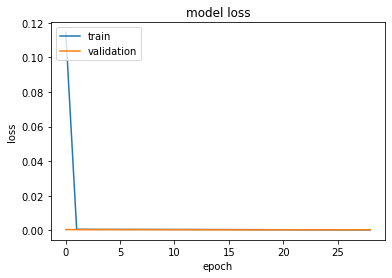

In [7]:
#Plotting training history

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [8]:
# Testing the model and saving result to a wav file

x_test = x[:x.shape[0]//2]
y_test = model.predict(x_test)

y_test = y_test.reshape((1,y_test.shape[0]*y_test.shape[1]))[0] #Join chuncks to a single audio signal
y_test = treble_unboost(y_test, 1000, 2, 44100) #Unboost treble (1KHz-20KHz)
y_test = butter_lowpass_filter(y_test, 10000, 44100, 10) #Cut frequencies above 10KHz

wave.write(f'{amplifier}_lstm_predict.wav', 44100, y_test)